In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df_reviews = pd.read_csv('rt_reviews.csv', encoding='latin1')

# Divide the dataset into train, development, and test sets
train, dev_test = train_test_split(df_reviews, test_size=0.3, random_state=42)
dev, test = train_test_split(dev_test, test_size=0.5, random_state=42)





In [4]:
print(train)

       Freshness                                             Review
216041    rotten   Does one really have to so debase Christ's st...
152466    rotten   People richer than you get paid to come up wi...
179147     fresh   While it doesn't exactly take your breath awa...
17383     rotten   One really bad movie, folks. Don't be a fool ...
199376    rotten                             All hat, no tentacles.
...          ...                                                ...
259178     fresh   At its best, with Soviets, Americans and Raim...
365838    rotten                Just Friends is a dumb teen comedy.
131932    rotten   Fairly successful at faking some pretty cool ...
146867     fresh   The pacing misses a few beats and the satire ...
121958    rotten   How do our flighty young heroines fight back?...

[336000 rows x 2 columns]


In [5]:
# Add flag column. If rotten, then value = 1. Else value = 0
df_reviews['rotten_flag'] = df_reviews['Freshness'].map( {'rotten': 1, 'fresh': 0, 'none':-1} ).astype(int)

# Choose only rows with 'rotten_flag' != -1
df_reviews_final = df_reviews[df_reviews['rotten_flag']!=-1].copy()  # Make a copy to avoid SettingWithCopyWarning


# Adding column to capture length of review for each review
df_reviews_final['length'] = df_reviews_final['Review'].apply(len)
#from refrence [1]

In [6]:
print(df_reviews_final.head(10))


  Freshness                                             Review  rotten_flag  \
0     fresh   Manakamana doesn't answer any questions, yet ...            0   
1     fresh   Wilfully offensive and powered by a chest-thu...            0   
2    rotten   It would be difficult to imagine material mor...            1   
3    rotten   Despite the gusto its star brings to the role...            1   
4    rotten   If there was a good idea at the core of this ...            1   
5    rotten   Gleeson goes the Hallmark Channel route, dama...            1   
6     fresh   It was the height of satire in 1976: dark as ...            0   
7    rotten   Everyone in "The Comedian" deserves a better ...            1   
8    rotten   Actor encourages grumpy Christians to embrace...            1   
9     fresh          Slight, contained, but ineffably soulful.            0   

   length  
0     147  
1      86  
2      82  
3     106  
4     167  
5     111  
6     186  
7      72  
8      58  
9      42 

In [7]:
# Group reviews by freshness and compute average review length for each group
grouped_reviews = df_reviews_final.groupby('Freshness')['length'].mean()

# Print the result
print(grouped_reviews)


Freshness
fresh     133.848100
rotten    129.610767
Name: length, dtype: float64


fresh     240000
rotten    240000
Name: Freshness, dtype: int64


<Axes: >

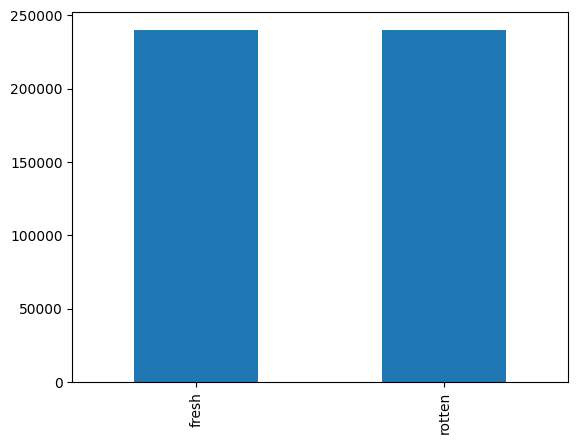

In [8]:
# print value counts for rotten and fresh
print(df_reviews_final['Freshness'].value_counts())
df_reviews_final['Freshness'].value_counts().plot.bar()
# so we can see that the dataset is well balanced

In [12]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


# Choose only english stop words
eng_SW = stopwords.words("english")
# refrenced from [1]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [13]:
# define the function to remove stop words
def remove_punctuation_and_stopwords(message):
    
    # remove punctuation characters using list comprehension
    msg_no_punctuation = [char for char in message if char not in string.punctuation]
    msg_no_punctuation = "".join(msg_no_punctuation).split() # join each word and then split at spaces
    
    # remove stopwords and create new list of words
    msg_no_punctuation_no_stopwords = [word.lower() for word in msg_no_punctuation if word.lower() not in eng_SW]
    return msg_no_punctuation_no_stopwords

In [14]:
#checking to see if my function is working properly
message = "Hello, world! This is a test message."
clean_message = remove_punctuation_and_stopwords(message)
print(clean_message)


['hello', 'world', 'test', 'message']


In [16]:
# fit bag of words model by removing punctuations and stop words (using remove_punctuation_and_stopwords function)
from sklearn.feature_extraction.text import CountVectorizer
bag_of_words_model_object = CountVectorizer(analyzer = remove_punctuation_and_stopwords).fit(df_reviews_final['Review'])

In [17]:
sample = bag_of_words_model_object.vocabulary_ # sample will be a dict of words as keys and the count as their values
print("There are",len(sample),"unique words after cleaning the messages in the bag of words")
# print(sample)

There are 132401 unique words after cleaning the messages in the bag of words


In [40]:
from sklearn.model_selection import train_test_split

# randomly split the dataset into train and test with 67% of the data in the training set and 33% in the test set
X_train, X_test, y_train, y_test = train_test_split(df_reviews_final["Review"], df_reviews_final["rotten_flag"], test_size=0.33, random_state=5)
#refrenced from [1]

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer


''' Use Pipeline to sequentially apply an intermediate list of 
    transforms and fits to obtain a final estimator. The final estimator should
    only implement fit with the training data to train the model. 
'''

pipe_MNB = Pipeline([('bow'  , CountVectorizer(min_df = 1e-4, analyzer = remove_punctuation_and_stopwords) ),
                     ('tfidf'   , TfidfTransformer()),
                     ('clf_MNB' , MultinomialNB(alpha=0.1)),
                    ])
#refrenced from [1]

In [22]:
# Fit the model to the training data
pipe_MNB.fit(X = X_train, y = y_train)
#refrenced from [1]

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function remove_punctuation_and_stopwords at 0x00000289745E6160>,
                                 min_df=0.0001)),
                ('tfidf', TfidfTransformer()),
                ('clf_MNB', MultinomialNB(alpha=0.1))])

In [23]:
from sklearn.metrics import accuracy_score

# Predict the values for the test data set
y_pred_MNB = pipe_MNB.predict(X_test)


# Calculate the accuracy of the classification
accuracy_ratio = accuracy_score(y_test,y_pred_MNB) # proportion of correct predictions
print("MNB predicted reviews with an accuracy of",accuracy_ratio*100,"%")
#refrenced from [1]

MNB predicted reviews with an accuracy of 78.50568181818181 %


In [24]:
docs_with_the = [doc for doc in train['Review'] if 'the' in doc.split()]


In [25]:
num_docs_with_the = len(docs_with_the)


In [26]:
p_the = num_docs_with_the / len(train)


In [29]:
if "the" in bag_of_words_model_object.vocabulary_:
    print("The word 'the' is in the vocab dictionary")
else:
    print("The word 'the' is not in the vocab dictionary")
# since I only consider the important keywords in my bag of words the word 'the' is not in my vocab

The word 'the' is not in the vocab dictionary


In [30]:
print(bag_of_words_model_object.vocabulary_)
# as you can see in the following print that bag of words only has keywords which will help us predict the actual outcome of the review


{'manakamana': 70031, 'doesnt': 32769, 'answer': 6131, 'questions': 93755, 'yet': 131205, 'makes': 69747, 'point': 88967, 'nepal': 78503, 'like': 66979, 'rest': 97295, 'planet': 88289, 'picturesque': 87619, 'far': 40830, 'peaceable': 86041, 'kingdom': 63496, 'wilfully': 129272, 'offensive': 81565, 'powered': 90342, 'chestthumping': 20368, 'machismo': 69231, 'good': 48806, 'clean': 21688, 'fun': 45799, 'would': 130425, 'difficult': 31052, 'imagine': 57171, 'material': 71191, 'wrong': 130646, 'spade': 109442, 'lost': 68253, 'found': 44563, 'despite': 30298, 'gusto': 50742, 'star': 110970, 'brings': 15734, 'role': 98895, 'hard': 52021, 'ride': 98095, 'shotgun': 105384, 'hectors': 53109, 'voyage': 126801, 'discovery': 31787, 'idea': 56691, 'core': 25219, 'film': 42253, 'buried': 16745, 'unsightly': 124391, 'pile': 87759, 'flatulence': 43259, 'jokes': 61690, 'dogrelated': 32851, 'bad': 9620, 'puns': 93106, 'ridiculous': 98128, 'serial': 103993, 'arson': 7659, 'plot': 88638, 'gleeson': 48208

In [42]:
p_the = num_docs_with_the / len(train)
print(f"The probability of documents containing the word 'the' in the  set is {p_the:.2%}")
# since we were asked to print the value of the it is 57.15% in the set


The probability of documents containing the word 'the' in the  set is 57.15%


In [32]:
# Calculate the occurrence probability of 'the' in the set
num_docs_with_the = sum(1 for doc in train['Review'] if 'the' in doc.split())
p_the = num_docs_with_the / len(train['Review'])
print("The occurrence probability of 'the' in the set is:", p_the)


The occurrence probability of 'the' in the training set is: 0.5714613095238095


In [35]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_df, test_df = train_test_split(df_reviews_final, test_size=0.2, random_state=42)

# Split train set into train and dev sets
train_df, dev_df = train_test_split(train_df, test_size=0.25, random_state=42)



In [36]:
print(dev_df.head())

       Freshness                                             Review  \
348141     fresh   Raul Ruiz's head-spinning Mysteries of Lisbon...   
333816    rotten   The film may be too preposterous to take seri...   
212925    rotten   ... introduces two compelling storylines but ...   
135115     fresh   Think 'good' Sam Raimi (Evil Dead 2, The Gift...   
129689     fresh                     Strange, eccentric, diverting.   

        rotten_flag  length  
348141            0     116  
333816            1     136  
212925            1      79  
135115            0     116  
129689            0      31  


In [39]:
# Predict the values for the dev data set
y_pred_dev = pipe_MNB.predict(dev_df['Review'])

# Calculate the accuracy of the classification
accuracy_dev = accuracy_score(dev_df['rotten_flag'], y_pred_dev) # proportion of correct predictions
print("MNB predicted dev reviews with an accuracy of", accuracy_dev*100, "%")
# since the professor has told us to work on the dev dataset insted of test data so we used the dev and the acurracy has improved by 1.4% after
#preprocessing


MNB predicted dev reviews with an accuracy of 79.23020833333332 %


In [ ]:
# refrences : 
#[1] - https://github.com/ashwin-srinivas7/SentimentAnalysis---Rottentomatoes/blob/master/A3%20-%20Data%20Mining%20and%20Analysis.ipynb
#[2] - https://www.upgrad.com/blog/multinomial-naive-bayes-explained/
#[3] - http://ankoorb.blogspot.com/2014/12/sentiment-analysis-on-rotten-tomatoes.html
#[4] - http://sentiment.christopherpotts.net/tokenizing.html